# Data Preparation
***
## Data Collection
***

In [1]:
import pandas as pd
import numpy as np

# Load RawData
rawData = pd.read_csv("../Data/Almond.csv")

***
## Data Exploration and Vizualization
***

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplot(column, data):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

print(rawData.info())

stats = rawData.describe()
print(stats)
missing_values_count = rawData.isnull().sum()

print("Missing values per feature:")
print(missing_values_count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2803 entries, 0 to 2802
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        2803 non-null   int64  
 1   Length (major axis)       1946 non-null   float64
 2   Width (minor axis)        1861 non-null   float64
 3   Thickness (depth)         1799 non-null   float64
 4   Area                      2803 non-null   float64
 5   Perimeter                 2803 non-null   float64
 6   Roundness                 1946 non-null   float64
 7   Solidity                  2803 non-null   float64
 8   Compactness               2803 non-null   float64
 9   Aspect Ratio              1004 non-null   float64
 10  Eccentricity              1004 non-null   float64
 11  Extent                    2803 non-null   float64
 12  Convex hull(convex area)  2803 non-null   float64
 13  Type                      2803 non-null   object 
dtypes: float

In [3]:
correlation_matrix = rawData.drop(['Id', 'Type'], axis=1).corr()
print(correlation_matrix)

                          Length (major axis)  Width (minor axis)  \
Length (major axis)                  1.000000            0.837034   
Width (minor axis)                   0.837034            1.000000   
Thickness (depth)                    0.457854            0.594621   
Area                                 0.759006            0.474224   
Perimeter                            0.809442            0.445872   
Roundness                           -0.324040            0.028531   
Solidity                            -0.184822           -0.030441   
Compactness                          0.253359            0.095097   
Aspect Ratio                         0.500352           -0.044345   
Eccentricity                         0.490871           -0.034087   
Extent                              -0.007200           -0.033799   
Convex hull(convex area)             0.783393            0.478885   

                          Thickness (depth)      Area  Perimeter  Roundness  \
Length (major axis)    

***
## Imputation
***

In [4]:
# Import Sklearn libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Retrieve Length, Width and Thickness for imputation
# Aswell as Area
# rawData_no_outliers.reset_index(drop=True, inplace=True)
p_LWTA = rawData[['Length (major axis)','Width (minor axis)','Thickness (depth)','Area']].copy()
# Set Area to NaN where length is NaN
p_LWTA['Area'] = np.where(p_LWTA['Length (major axis)'].notna(),
                          p_LWTA['Area'],
                          np.nan)

# Use iterative imputation using sklearn
imputer = IterativeImputer(max_iter=10, random_state=0)
d_LWTA_imputed = pd.DataFrame(imputer.fit_transform(p_LWTA), columns=p_LWTA.columns)

# Calculate Roundness using the imputed Area when there is length
d_LWTA_imputed['Roundness'] = 4 * d_LWTA_imputed['Area'] / (np.pi * d_LWTA_imputed['Length (major axis)']**2)

# Remove irrelavent features
p_proc = rawData.drop(columns=['Id']).copy()
p_proc[['Length (major axis)','Width (minor axis)','Thickness (depth)','Roundness']] = d_LWTA_imputed[['Length (major axis)','Width (minor axis)','Thickness (depth)','Roundness']]
p_proc['Aspect Ratio'] = p_proc['Length (major axis)']/p_proc['Width (minor axis)']
p_proc['Eccentricity'] = (1 - (p_proc['Width (minor axis)']/p_proc['Length (major axis)'])**2) ** 0.5

***
## Handling Potential Bias
***

In [5]:
from imblearn.under_sampling import RandomUnderSampler

In [6]:
X = p_proc[['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness', 'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)']]
Y = p_proc['Type']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, Y)

X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Type')

print(X_resampled.shape)
print(y_resampled.shape)

(2781, 12)
(2781,)


***
## Data Split
***

In [7]:
# Import libraries for NN
# Pretty sure this shit is just magic
import torch
from sklearn.preprocessing import LabelEncoder

X_resampled.reset_index(drop=True, inplace=True)
y_resampled.reset_index(drop=True, inplace=True)

# Label encoding (Not Really?)
label_encoder = LabelEncoder()

# X,Y -> X_tensor,Y_tensor
X_tensor = torch.tensor(X_resampled.values, dtype=torch.float32)
y_tensor = torch.tensor(label_encoder.fit_transform(y_resampled), dtype=torch.long)

# Splitting Dataset into training, validation, and testing sets
# Train + (Val | Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, 
    y_tensor, 
    test_size=0.3, 
    stratify=y_tensor, 
    random_state=21
)

# Val + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=1/3, 
    stratify=y_temp, 
    random_state=69
)

# Check the distribution of classes in each set
print("Training set class distribution:\n", pd.Series(y_train).value_counts(normalize=True))
print("Validation set class distribution:\n", pd.Series(y_val).value_counts(normalize=True))
print("Testing set class distribution:\n", pd.Series(y_test).value_counts(normalize=True))


# Apply training data transformation across all three sets for consistency
mean = X_train.mean(dim=0)
std = X_train.std(dim=0)

X_train_norm = (X_train - mean)/std
X_val_norm = (X_val - mean)/std
X_test_norm = (X_test - mean)/std


Training set class distribution:
 0    0.333505
2    0.333505
1    0.332991
Name: proportion, dtype: float64
Validation set class distribution:
 1    0.334532
0    0.332734
2    0.332734
Name: proportion, dtype: float64
Testing set class distribution:
 1    0.333333
2    0.333333
0    0.333333
Name: proportion, dtype: float64


***
## Neural Network Definitions
***

In [8]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Func
import torch.nn.init as init

class FirstLayer(nn.Module):
    def __init__(self, output_size, activation='relu', init_method='he'):
        super(FirstLayer, self).__init__()
        self.fc = nn.Linear(12, output_size)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        if init_method == 'he':
            init.kaiming_normal_(self.fc.weight, nonlinearity='relu')
        elif init_method == 'xavier':
            init.xavier_normal_(self.fc.weight)
        else:
            raise ValueError(f"Unsupported initialization method: {init_method}")

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class OutputLayer(nn.Module):
    def __init__(self, input_size):
        super(OutputLayer, self).__init__()
        self.fc = nn.Linear(input_size, 3)

    def forward(self, x):
        x = self.fc(x)
        return x

class ReluLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(ReluLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.ReLU()
        init.kaiming_normal_(self.fc.weight, nonlinearity='relu')
        self.out_features = output_size

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class LeakyReluLayer(nn.Module):
    def __init__(self, input_size, output_size, neg_slope=0.01):
        super(LeakyReluLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.LeakyReLU(negative_slope=neg_slope)
        init.kaiming_normal_(self.fc.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class PReLULayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(PReLULayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.PReLU()
        init.kaiming_normal_(self.fc.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class SigmoidLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(SigmoidLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.activation = nn.Sigmoid()
        init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class SwishLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(SwishLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.partial_activation = nn.Sigmoid()
        init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        x = self.fc(x)
        return x * self.partial_activationti(x)


In [9]:
class DynamicNN(nn.Module):
    def __init__(self, no_hidden_layers, first_layer_neurons, alpha):
        super(DynamicNN, self).__init__()
        self.in_layer = FirstLayer(output_size=first_layer_neurons)
        hidden_layers = []
        
        current_neurons = first_layer_neurons
        
        for i in range(no_hidden_layers):
            if i > 0:
                current_neurons = max(int(first_layer_neurons * (1 - alpha * i)), 3)
                hidden_layers.append(ReluLayer(input_size=hidden_layers[-1].out_features, output_size=current_neurons))
            else:
                hidden_layers.append(ReluLayer(input_size=first_layer_neurons, output_size=current_neurons))
        
        
        self.out = OutputLayer(input_size=current_neurons)

        self.model = nn.Sequential(*hidden_layers)

    def forward(self, x):
        x = self.in_layer(x)
        x = self.model(x)
        return self.out(x)
        
    def print_structure(self):
        print("Input Layer: ", self.in_layer)
        for i, layer in enumerate(self.model):
            print(f"Hidden Layer {i + 1}: {layer}")
        print("Output Layer: ", self.out)

In [10]:
class NeuralNetworkA(nn.Module):
    def __init__(self):
        super(NeuralNetworkA, self).__init__()
        self.l1 = FirstLayer(8)
        self.l2 = ReluLayer(8,6)
        self.l3 = OutputLayer(6)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

In [11]:
class NeuralNetworkB(nn.Module):
    def __init__(self):
        super(NeuralNetworkB, self).__init__()
        self.l1 = FirstLayer(8)
        self.l2 = LeakyReluLayer(8,6)
        self.l3 = OutputLayer(6)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

In [12]:
class NeuralNetworkC(nn.Module):
    def __init__(self):
        super(NeuralNetworkC, self).__init__()
        self.l1 = FirstLayer(8)
        self.l2 = SwishLayer(8,6)
        self.l3 = OutputLayer(6)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

***
## Helpers
***

In [13]:
from enum import Enum

class Optimizer(Enum):
    ADAM = 0        # Adam
    RPROP = 1       # Resilient Backpropagation
    SGD = 2         # Schocastic Gradient Decent

class Criterion(Enum):
    CEL = 0         # CrossEntropyLoss
    BCEWLL = 1      # BCEWithLogitsLoss

class Model(Enum):
    A = 0
    B = 1
    C = 2
    
def optimizerSelect(opt: Optimizer):
    if opt == Optimizer.ADAM:
        return optim.Adam
    elif opt == Optimizer.RPROP:
        return optim.Rprop
    else:
        return optim.SGD

def criterionSelect(opt: Criterion):
    if opt == Criterion.CEL:
        return nn.CrossEntropyLoss()
    elif opt == Criterion.BCEWLL:
        return nn.BCEWithLogitsLoss()

def modelSelect(opt: Model):
    if opt == Model.A:
        return NeuralNetworkA()
    elif opt == Model.B:
        return NeuralNetworkB()
    elif opt == Model.C: 
        return NeuralNetworkC()

def convert_tensor(X,Y,batch,shuffle):
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, Y), batch_size=batch, shuffle=shuffle)

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [14]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
    
    accuracy = correct_predictions / total_samples
    return total_loss / len(val_loader), accuracy

In [15]:
def detailed_train_model(model, num_epochs, train_loader, criterion, optimizer):
    model.train()
    loss_per_batch = []
    loss_per_epoch = []
    
    grad_list = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            grad_list[name] = []
    
    average_loss = 0.0
    total_loss = 0.0
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_per_batch.append(loss.item())
            epoch_loss += loss.item()
            
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                grad_list[name].append(param.grad.abs().mean().item())
            
        average_loss = epoch_loss / len(train_loader)
        loss_per_epoch.append(average_loss)
        total_loss += average_loss
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    average_loss = total_loss / num_epochs
    for layer_name, gradients in grad_list.items():
        plt.plot(gradients, label=layer_name)
    plt.xlabel("Epochs")
    plt.ylabel("Average Gradient Magnitude")
    plt.legend()
    plt.title("Gradient Flow Over Time")
    plt.show()
    return loss_per_batch, loss_per_epoch, average_loss

def plot_loss(batch_loss_values, epoch_loss_values, num_epochs):
    plt.figure(figsize=(12, 6))

    plt.plot(batch_loss_values, label='Batch Loss', color='blue', linestyle='-', linewidth=2)

    epochs = list(range(1, num_epochs + 1))
    plt.plot([epoch * len(batch_loss_values) // num_epochs - 1 for epoch in epochs], epoch_loss_values, 
             label='Average Epoch Loss', color='orange', linestyle='--', marker='o')

    plt.title('Loss over Batches and Average Loss per Epoch')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and "bias" not in n:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().item())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title("Gradient flow")
    plt.grid(True)

def compute_grad_norm(named_parameters):
    grad_norms = []
    for name, param in named_parameters:
        if param.requires_grad and param.grad is not None:
            grad_norm = param.grad.norm(2).item()
            grad_norms.append((name, grad_norm))
    return grad_norms

***
## K-Fold cross Validation Defintions
***

In [16]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

def k_fold_cross_val(
    model_opt: Model, 
    criterion_opt: Criterion, 
    optimizer_opt: Optimizer, 
    X_tensor, 
    Y_tensor, 
    k: int, 
    num_epochs: int,
    learning_rate,
    batch_size: int,
    verbose: bool = True
):
    dataset = TensorDataset(X_tensor, Y_tensor)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=21)
    
    fold_results = {
        'accuracy': [],
        'validation_loss': [],
        'training_loss': [],
        'training_accuracy': [],
        'confusion_matrices': [],
        'classification_reports': []
    }
    
    for fold, (train_index, val_index) in enumerate(skf.split(X_tensor, Y_tensor)):
        
        train_loader = DataLoader(dataset=dataset, sampler=torch.utils.data.SubsetRandomSampler(train_index), batch_size=batch_size)
        val_loader = DataLoader(dataset=dataset, sampler=torch.utils.data.SubsetRandomSampler(val_index), batch_size=batch_size)
        
        model = modelSelect(opt=model_opt)
        criterion = criterionSelect(opt=criterion_opt)
        optimizer = optimizerSelect(opt=optimizer_opt)(model.parameters(), lr=learning_rate)
        
        fold_training_loss = []
        fold_training_accuracy = []

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            avg_loss = epoch_loss / len(train_loader)
            avg_accuracy = correct / total
            
            fold_training_loss.append(avg_loss)
            fold_training_accuracy.append(avg_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
    
        accuracy = correct / total
        fold_results['accuracy'].append(accuracy)
        fold_results['training_loss'].append(sum(fold_training_loss) / len(fold_training_loss))
        fold_results['training_accuracy'].append(sum(fold_training_accuracy) / len(fold_training_accuracy))
        fold_results['validation_loss'].append(val_loss / len(val_loader))
        fold_results['confusion_matrices'].append(confusion_matrix(all_labels, all_predictions))
        fold_results['classification_reports'].append(classification_report(all_labels, all_predictions, output_dict=True))
        
        if verbose:
            print(f"Fold {fold + 1}:")
            print(f"  Training Loss: {sum(fold_training_loss) / len(fold_training_loss):.4f}")
            print(f"  Training Accuracy: {sum(fold_training_accuracy) / len(fold_training_accuracy):.4f}")
            print(f"  Validation Accuracy: {accuracy:.4f}")
            print(f"  Validation Loss: {val_loss / len(val_loader):.4f}")

    return fold_results


In [17]:
from tabulate import tabulate

def display_k_fold_results(fold_results):
    
    table_data = []

    for fold in range(len(fold_results['accuracy'])):
        table_data.append([
            fold + 1,
            fold_results['training_loss'][fold],
            fold_results['training_accuracy'][fold],
            fold_results['validation_loss'][fold],
            fold_results['accuracy'][fold]
        ])

    headers = ["Fold", "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"]

    print("K-Fold Cross-Validation Results:")
    print(tabulate(table_data, headers=headers, tablefmt='grid'))

    for fold, confusion_matrix in enumerate(fold_results['confusion_matrices'], start=1):
        print(f"\nConfusion Matrix for Fold {fold}:\n{confusion_matrix}")

    for fold, report in enumerate(fold_results['classification_reports'], start=1):
        print(f"\nClassification Report for Fold {fold}:\n{tabularize_classification_report(report)}")


def tabularize_classification_report(report):
    rows = []
    
    for label, metrics in report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            row = [
                label,
                metrics['precision'],
                metrics['recall'],
                metrics['f1-score'],
                metrics['support']
            ]
            rows.append(row)
    
    averages = report['macro avg']
    weighted_averages = report['weighted avg']
    
    rows.append([
        'Macro Avg',
        averages['precision'],
        averages['recall'],
        averages['f1-score'],
        averages['support']
    ])

    rows.append([
        'Weighted Avg',
        weighted_averages['precision'],
        weighted_averages['recall'],
        weighted_averages['f1-score'],
        weighted_averages['support']
    ])
    
    headers = ['Class', 'Precision', 'Recall', 'F1-score', 'Support']
    
    return tabulate(rows, headers=headers, tablefmt='pretty')


***
## Grid Search with K fold validation
***

In [18]:
def grid_search(
    model_opt: Model, 
    criterion_opt: Criterion, 
    optimizer_opt: Optimizer, 
    X_tensor, 
    Y_tensor, 
    k: int, 
    batch_size: int,
    num_epochs_array: list[int], 
    learning_rate_array: list[int]
):
    grid_results = []
    
    for lr in learning_rate_array:
        for num_epochs in num_epochs_array:
            print(f"Training with Learning Rate: {lr}, Epochs: {num_epochs}")
            fold_results = k_fold_cross_val(
                model_opt=model_opt,
                criterion_opt=criterion_opt,
                optimizer_opt=optimizer_opt,
                X_tensor=X_tensor,
                Y_tensor=Y_tensor,
                k=k,
                num_epochs=num_epochs,
                learning_rate=lr,
                batch_size=batch_size,
                verbose=False
            )
            
            avg_accuracy = np.mean(fold_results['accuracy'])
            avg_training_loss = np.mean(fold_results['training_loss'])
            avg_training_accuracy = np.mean(fold_results['training_accuracy'])
            avg_validation_loss = np.mean(fold_results['validation_loss'])

            grid_results.append({
                'learning_rate': lr,
                'num_epochs': num_epochs,
                'avg_accuracy': avg_accuracy,
                'avg_training_loss': avg_training_loss,
                'avg_training_accuracy': avg_training_accuracy,
                'avg_validation_loss': avg_validation_loss
            })
    
    results_df = pd.DataFrame(grid_results)
    return results_df

In [38]:
def plot_grid_search_results(results_df, save: bool = False, file_path: str = "./images/grid_search.png"):
    training_accuracy_pivot = results_df.pivot(index="num_epochs", columns="learning_rate", values="avg_training_accuracy")
    accuracy_pivot = results_df.pivot(index="num_epochs", columns="learning_rate", values="avg_accuracy")

    training_loss_pivot = results_df.pivot(index="num_epochs", columns="learning_rate", values="avg_training_loss")
    loss_pivot = results_df.pivot(index="num_epochs", columns="learning_rate", values="avg_validation_loss")
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    sns.heatmap(training_accuracy_pivot, annot=True, fmt=".3f", cmap="YlGnBu", ax=axs[0, 0])
    axs[0,0].set_title("Average Training Accuracy")
    axs[0,0].set_xlabel("Learning Rate")
    axs[0,0].set_ylabel("Number of Epochs")

    sns.heatmap(training_loss_pivot, annot=True, fmt=".3f", cmap="YlOrRd", ax=axs[0, 1])
    axs[0,1].set_title("Average Training Loss")
    axs[0,1].set_xlabel("Learning Rate")
    axs[0,1].set_ylabel("Number of Epochs")
    
    sns.heatmap(accuracy_pivot, annot=True, fmt=".3f", cmap="YlGnBu", ax=axs[1, 0])
    axs[1,0].set_title("Average Validation Accuracy")
    axs[1,0].set_xlabel("Learning Rate")
    axs[1,0].set_ylabel("Number of Epochs")

    sns.heatmap(loss_pivot, annot=True, fmt=".3f", cmap="YlOrRd", ax=axs[1, 1])
    axs[1,1].set_title("Average Validation Loss")
    axs[1,1].set_xlabel("Learning Rate")
    axs[1,1].set_ylabel("Number of Epochs")

    plt.tight_layout()
    if save:
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
num_epochs = [50, 100, 200, 500]
results = grid_search(
    model_opt=Model.A,
    criterion_opt=Criterion.CEL,
    optimizer_opt=Optimizer.ADAM,
    X_tensor=X_train_norm,
    Y_tensor=y_train,
    k=5,
    batch_size=32,
    learning_rate_array=learning_rates,
    num_epochs_array=num_epochs
)

Training with Learning Rate: 0.001, Epochs: 50
Training with Learning Rate: 0.001, Epochs: 100
Training with Learning Rate: 0.001, Epochs: 200
Training with Learning Rate: 0.001, Epochs: 500
Training with Learning Rate: 0.005, Epochs: 50
Training with Learning Rate: 0.005, Epochs: 100
Training with Learning Rate: 0.005, Epochs: 200
Training with Learning Rate: 0.005, Epochs: 500
Training with Learning Rate: 0.01, Epochs: 50
Training with Learning Rate: 0.01, Epochs: 100
Training with Learning Rate: 0.01, Epochs: 200
Training with Learning Rate: 0.01, Epochs: 500
Training with Learning Rate: 0.05, Epochs: 50
Training with Learning Rate: 0.05, Epochs: 100
Training with Learning Rate: 0.05, Epochs: 200
Training with Learning Rate: 0.05, Epochs: 500
Training with Learning Rate: 0.1, Epochs: 50


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classif

Training with Learning Rate: 0.1, Epochs: 100


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with Learning Rate: 0.1, Epochs: 200


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classif

Training with Learning Rate: 0.1, Epochs: 500


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classif

Training with Learning Rate: 0.5, Epochs: 50


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classif

Training with Learning Rate: 0.5, Epochs: 100


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classif

Training with Learning Rate: 0.5, Epochs: 200


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classif

Training with Learning Rate: 0.5, Epochs: 500


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classif

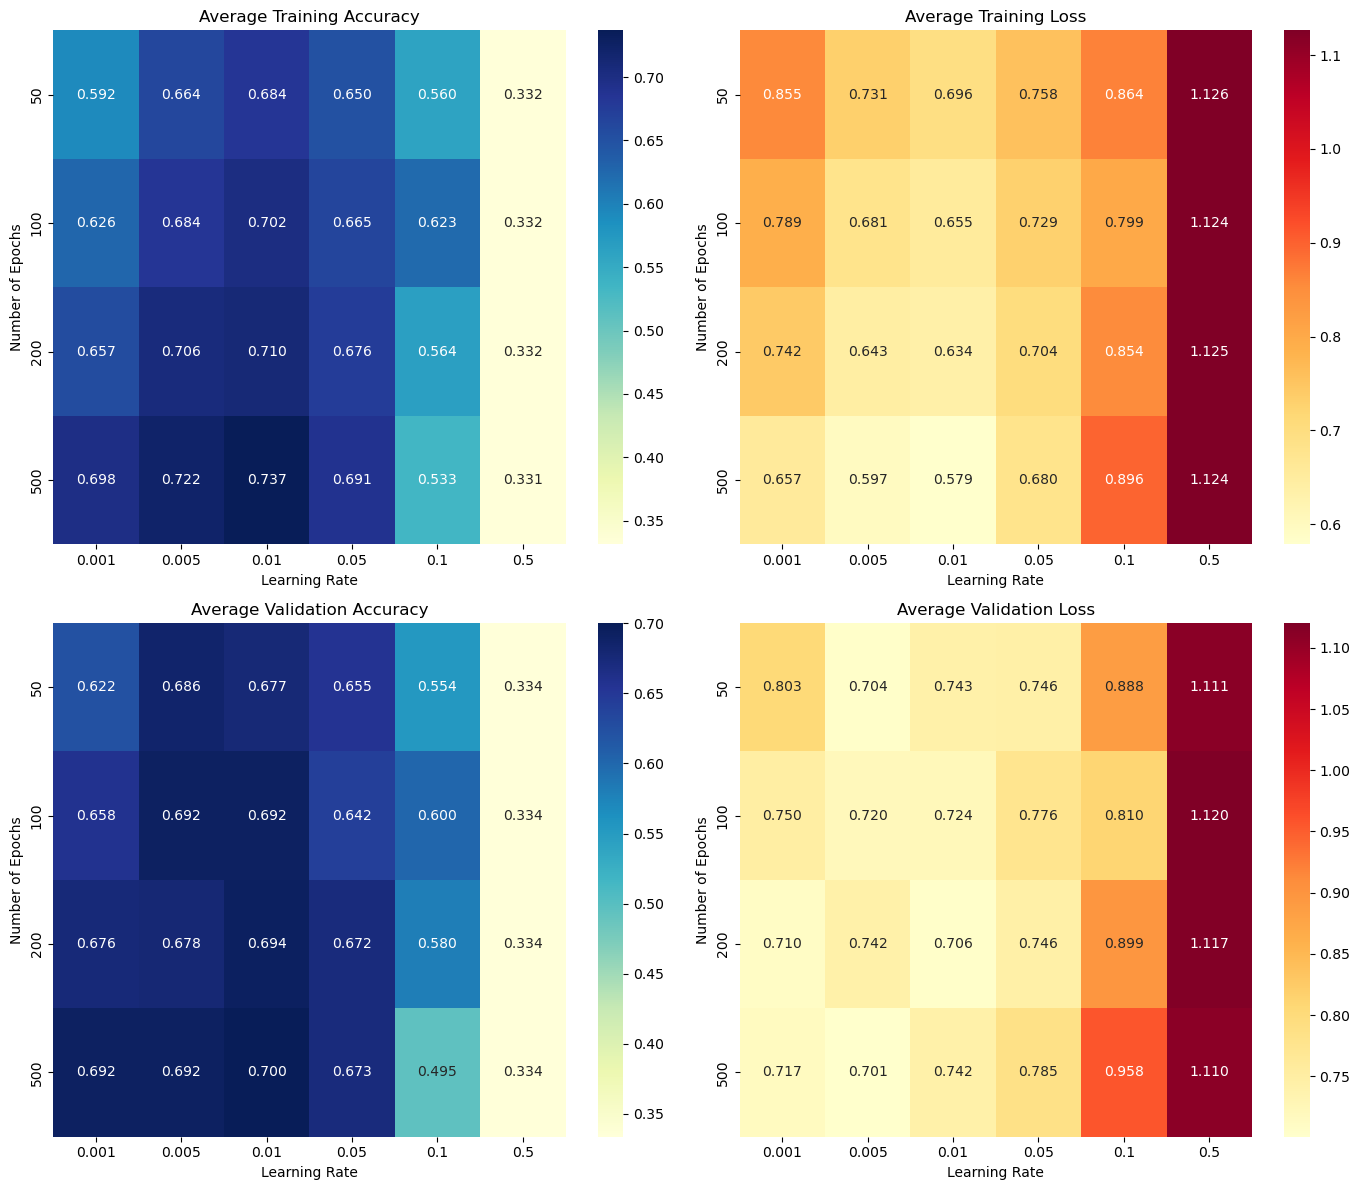

In [39]:
plot_grid_search_results(results, save=True, file_path="./images/test.png")

***
## Training Algorithms
***
### Shared Hyperparameters
***

In [22]:
learning_rate  =0.005
num_epochs = 300
batch_size = 34
criterion_opt = Criterion.CEL
random_seed = 42

***
## Adam
***

In [ ]:
optimizer_opt = Optimizer.ADAM

In [ ]:
model = NeuralNetworkA()
optimizer = optimizerSelect(optimizer_opt)(model.parameters(),lr=learning_rate)
criterion = criterionSelect(criterion_opt)
train_loader = convert_tensor(X_train_norm,y_train,batch=batch_size,shuffle=True)

In [ ]:
loss_per_batch, loss_per_epoch, average_loss = detailed_train_model(model=model, num_epochs=num_epochs, train_loader= train_loader, criterion= criterion, optimizer= optimizer)

In [ ]:
plot_loss(batch_loss_values=loss_per_batch,epoch_loss_values=loss_per_epoch,num_epochs=num_epochs)

In [ ]:
results = k_fold_cross_val(model_opt=Model.B,optimizer_opt=optimizer_opt,criterion_opt=criterion_opt,X_tensor=X_train_norm,Y_tensor=y_train,num_epochs=num_epochs,batch_size=batch_size,k=5)
display_k_fold_results(results)

***
## RProp
***

In [ ]:
optimizer_opt = Optimizer.RPROP

In [ ]:
model = MyNeuralNetwork()
optimizer = optimizerSelect(optimizer_opt)(model.parameters(),lr=learning_rate)
criterion = criterionSelect(criterion_opt)
train_loader = convert_tensor(X_train_norm,y_train,batch=batch_size,shuffle=True)

In [ ]:
loss = detailed_train_model(model=model, num_epochs=num_epochs, train_loader= train_loader, criterion= criterion, optimizer= optimizer)

***
## SGD
***

In [ ]:
optimizer_opt = Optimizer.SGD

In [ ]:
model = MyNeuralNetwork()
optimizer = optimizerSelect(optimizer_opt)(model.parameters(),lr=learning_rate)
criterion = criterionSelect(criterion_opt)
train_loader = convert_tensor(X_train_norm,y_train,batch=batch_size,shuffle=True)

In [ ]:
loss = detailed_train_model(model=model, num_epochs=num_epochs, train_loader= train_loader, criterion= criterion, optimizer= optimizer)

***
## Hybrid
***
### THE WORK AROUND
Instead of trying to make mutiple optimizers work on the same set of model parameters, use multiple seperate models and calculate and share updates between them

In [30]:
def hybrid_train_model(model_opt, criterion_opt, train_loader, num_epochs, learning_rate):
    
    modelAdam = modelSelect(opt=model_opt)
    modelRProp = modelSelect(opt=model_opt)
    modelSGD = modelSelect(opt=model_opt)
    criterion = torch.nn.CrossEntropyLoss()
    optimizerAdam = optim.Adam(modelAdam.parameters(), lr=learning_rate)
    optimizerRProp = optim.Rprop(modelRProp.parameters(), lr=learning_rate)
    optimizerSGD = optim.SGD(modelSGD.parameters(), lr=learning_rate)

    loss_per_batch = []
    loss_per_epoch = []

    total_loss = 0.0
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            
            optimizerAdam.zero_grad()
            optimizerRProp.zero_grad()
            optimizerSGD.zero_grad()
            
            outputsAdam = modelAdam(inputs)
            outputsRProp = modelRProp(inputs)
            outputsSGD = modelSGD(inputs)
            
            lossAdam = criterion(outputsAdam, labels)
            lossRProp = criterion(outputsRProp, labels)
            lossSGD = criterion(outputsSGD, labels)
            
            lossAdam.backward()
            lossRProp.backward()
            lossSGD.backward()
            
            optimizerAdam.step()
            optimizerRProp.step()
            optimizerSGD.step()

            updatesAdam = []
            updatesRProp = []
            updatesSGD = []

            with torch.no_grad():
                for param_adam, param_rprop, param_sgd in zip(modelAdam.parameters(), modelRProp.parameters() , modelSGD.parameters()):
                    if param_sgd.grad is not None and param_rprop.grad is not None and param_adam.grad is not None:
                        # Adam update
                        adam_update = -optimizerAdam.param_groups[0]['lr'] * param_adam.grad
                        updatesAdam.append(adam_update)

                        # RProp update
                        rprop_update = -optimizerRProp.param_groups[0]['lr'] * param_rprop.grad
                        updatesRProp.append(rprop_update)
                        
                        # SGD update
                        sgd_update = -optimizerSGD.param_groups[0]['lr'] * param_sgd.grad
                        updatesSGD.append(sgd_update)

            averaged_updates = [(adam + rprop + sgd) / 3 for adam, rprop, sgd in zip(updatesAdam, updatesRProp, updatesSGD)]

            with torch.no_grad():
                for param, update in zip(modelAdam.parameters(), averaged_updates):
                    param.data += update
                for param, update in zip(modelRProp.parameters(), averaged_updates):
                    param.data += update
                for param, update in zip(modelSGD.parameters(), averaged_updates):
                    param.data += update 
                

            batch_avg_loss = (lossAdam.item() + lossRProp.item() + lossSGD.item())/3
            loss_per_batch.append(batch_avg_loss)
            epoch_loss += batch_avg_loss
            
        average_loss = epoch_loss / len(train_loader)
        loss_per_epoch.append(average_loss)
        total_loss += average_loss
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    average_loss = total_loss / num_epochs
    
    return loss_per_batch, loss_per_epoch, average_loss

In [32]:
loss_per_batch, loss_per_epoch, average_loss = hybrid_train_model(
    model_opt=Model.A,
    criterion_opt=Criterion.CEL,
    train_loader=convert_tensor(
        X=X_train_norm,
        Y=y_train,
        batch=32,
        shuffle=True
    ),
    num_epochs=200,
    learning_rate=0.01
)

Epoch [1/200], Average Loss: 1.0567
Epoch [2/200], Average Loss: 0.9782
Epoch [3/200], Average Loss: 0.9530
Epoch [4/200], Average Loss: 0.9362
Epoch [5/200], Average Loss: 0.9248
Epoch [6/200], Average Loss: 0.9155
Epoch [7/200], Average Loss: 0.9057
Epoch [8/200], Average Loss: 0.8988
Epoch [9/200], Average Loss: 0.8867
Epoch [10/200], Average Loss: 0.8805
Epoch [11/200], Average Loss: 0.8767
Epoch [12/200], Average Loss: 0.8682
Epoch [13/200], Average Loss: 0.8645
Epoch [14/200], Average Loss: 0.8599
Epoch [15/200], Average Loss: 0.8534
Epoch [16/200], Average Loss: 0.8500
Epoch [17/200], Average Loss: 0.8499
Epoch [18/200], Average Loss: 0.8447
Epoch [19/200], Average Loss: 0.8383
Epoch [20/200], Average Loss: 0.8348
Epoch [21/200], Average Loss: 0.8304
Epoch [22/200], Average Loss: 0.8240
Epoch [23/200], Average Loss: 0.8213
Epoch [24/200], Average Loss: 0.8177
Epoch [25/200], Average Loss: 0.8176
Epoch [26/200], Average Loss: 0.8090
Epoch [27/200], Average Loss: 0.8051
Epoch [28/